# Paper 2

## GLM with correction for grey matter

In [3]:
%matplotlib inline
import glob
import numpy as np
import random
import pandas as pd
import seaborn as sns; sns.set()
import os
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt

from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker 
from nilearn import plotting,image, glm
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.connectome import ConnectivityMeasure

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import permutation_test_score
from pathlib import Path

from nltools.stats import fdr, norm

from sklearn.metrics import confusion_matrix

import joblib
import numpy as np
from pathlib import Path

# pour enlever les warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
Final_df = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

### Desgin matrix

<Axes: label='conditions', ylabel='scan number'>

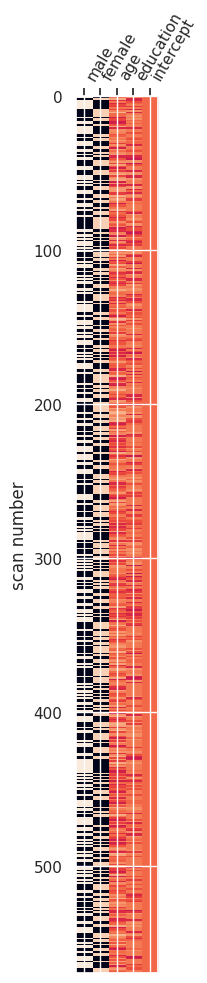

In [10]:
female_contrast = []
male_contrast = []

for i in range(0,len(Final_df["Gender"])):
    if Final_df["Gender"][i] == 0:
        male_contrast.append(1)
        female_contrast.append(0)
        
    elif Final_df["Gender"][i] == 1:
        male_contrast.append(0)
        female_contrast.append(1)
        
        
diff_sex = pd.DataFrame(
    {"subject_label" : Final_df["subject_label"],
     "male" : male_contrast,
     "female" : female_contrast,
     "age" : Final_df["Age_in_Yrs"],
     "education" : Final_df["SSAGA_Educ"]
    }
)


design_matrix_sex = glm.second_level.make_second_level_design_matrix(df_boot["subject_label"], diff_sex)
plotting.plot_design_matrix(design_matrix_sex)


In [12]:
models_sex = []
gray_masker = datasets.load_mni152_gm_mask()
seed = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_seed-{seed_name}_mean-4_voxelcorrelations.nii.gz"

for seeds in seed:
    maps = []
    for sub in Final_df["subject_label"]:
        img_path = img_tpl.format(seed_name=seeds, participant_id=sub)
        maps.append(img_path)

    glm_model = SecondLevelModel(mask_img=gray_masker)
    glm_model = glm_model.fit(maps, design_matrix=design_matrix_sex)
    models_sex.append(glm_model)

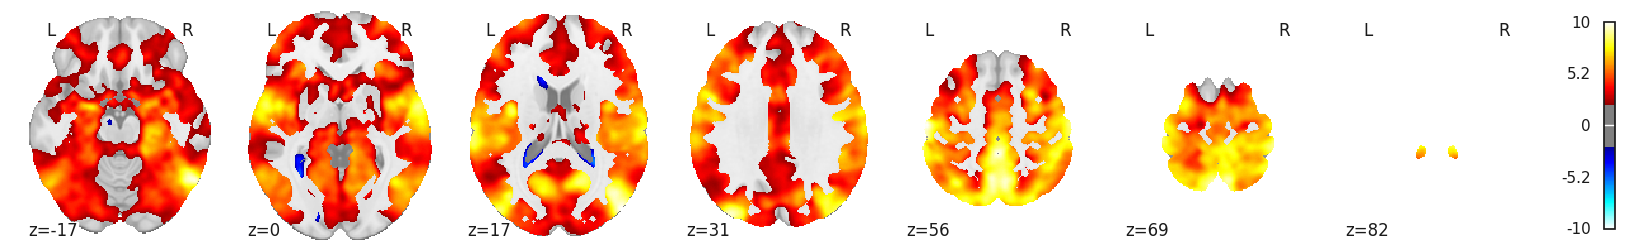

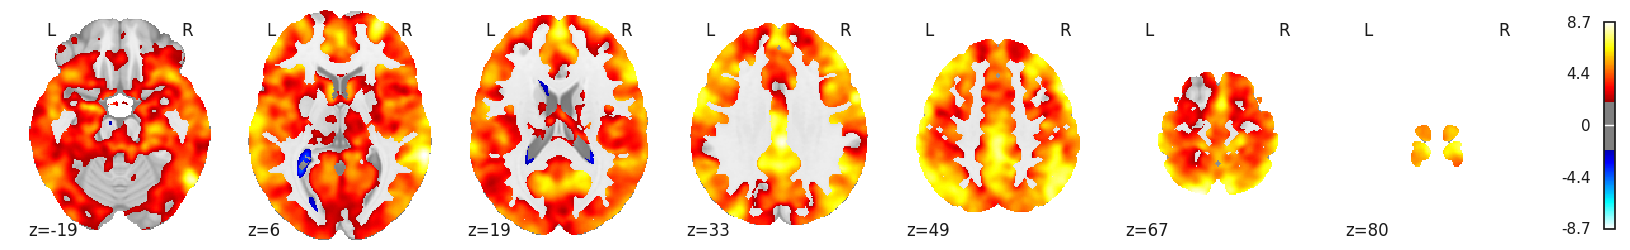

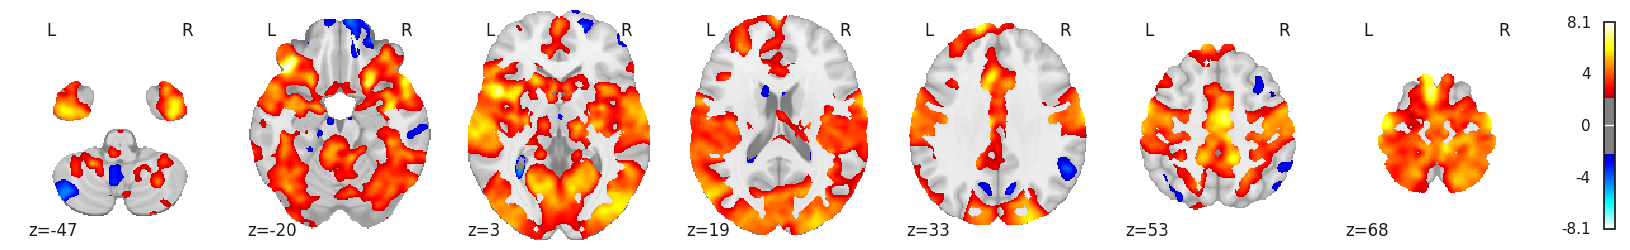

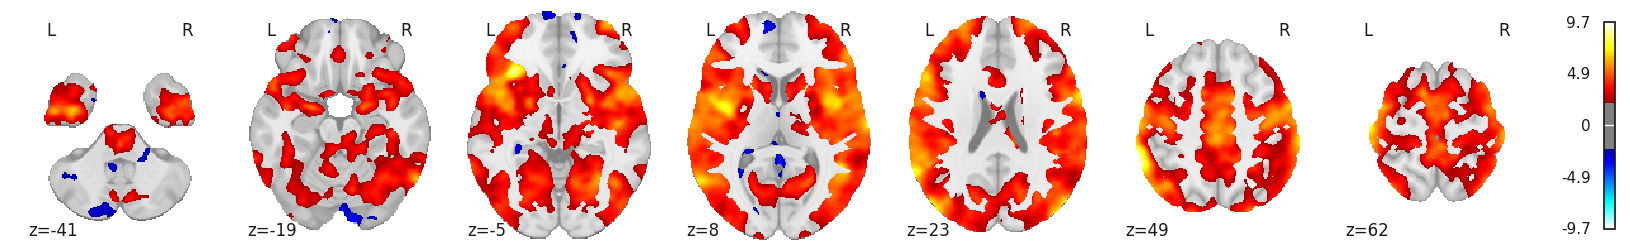

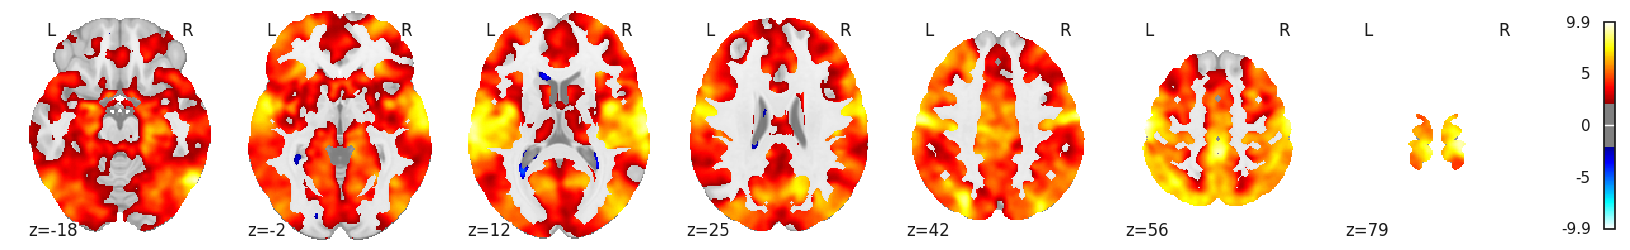

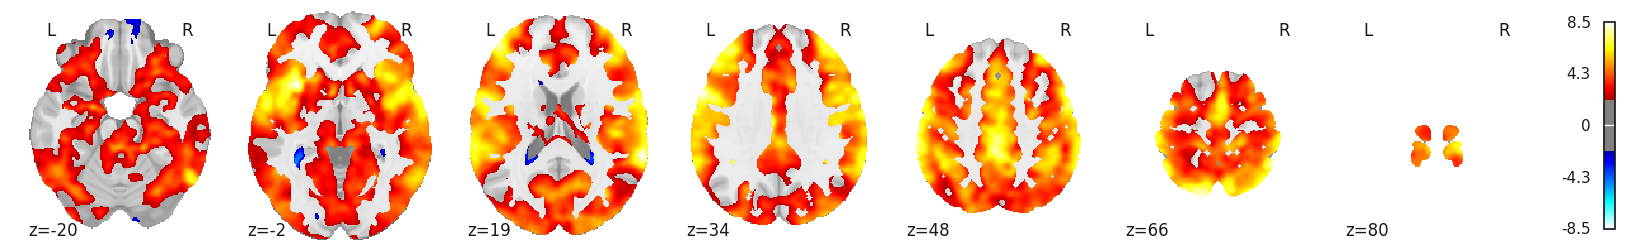

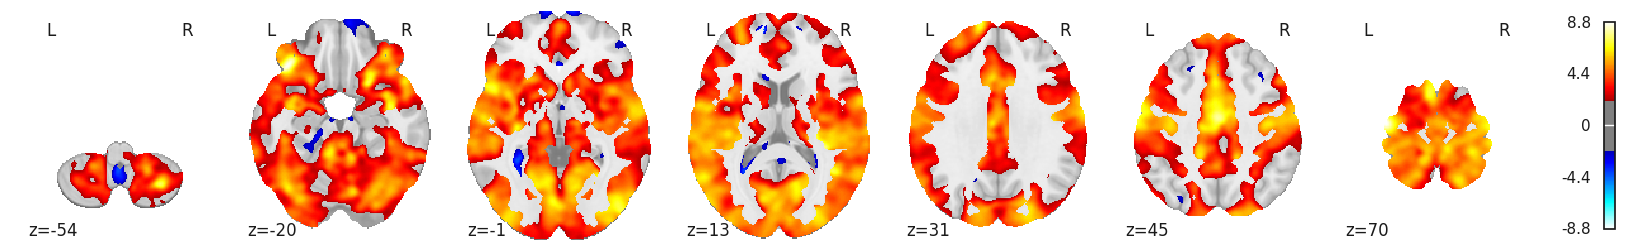

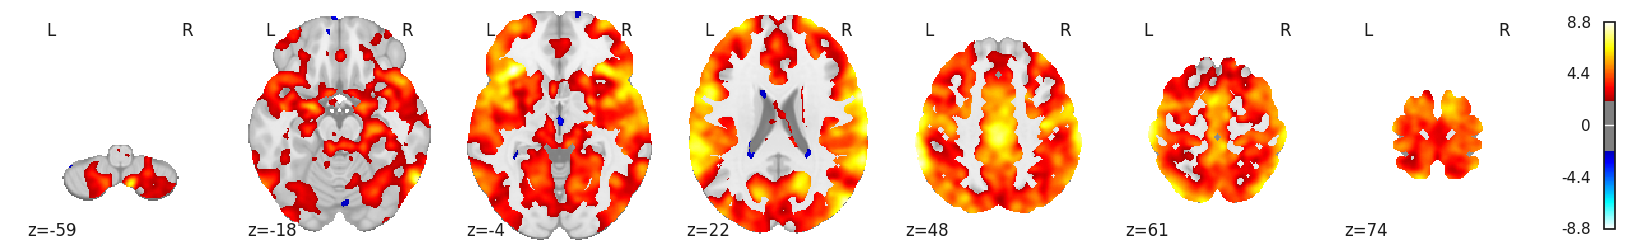

In [13]:
for i in range(0, len(models_sex)):
    
    z_map = models_sex[i].compute_contrast(second_level_contrast=[1,-1,0,0,0], output_type="z_score")
    
    clean_map, threshold = threshold_stats_img(z_map,
                                               alpha = 0.05,
                                               height_control="fdr",
                                               cluster_threshold=10)
    
    plotting.plot_stat_map(clean_map,
                           threshold = threshold,
                           colorbar=True,
                           display_mode="z")
    plotting.show()